In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import json
import bert
import tqdm
from bert.tokenization.bert_tokenization import FullTokenizer

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# https://www.youtube.com/watch?v=gE-95nFF4Cc 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# !gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output intent/train.csv
# !gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output intent/valid.csv
# !gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output intent/test.csv

In [4]:
train = pd.read_csv("intent/train.csv")
validation = pd.read_csv("intent/valid.csv")
test = pd.read_csv("intent/test.csv")


train=train.append(validation).reset_index()

In [5]:
train.shape

(13784, 3)

In [6]:
train.head()

,index,text,intent
0,0,listen to westbam alumb allergic on google music,PlayMusic
1,1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,2,i give this current textbook a rating value of...,RateBook
3,3,play the song little robin redbreast,PlayMusic
4,4,please add iris dement to my playlist this is ...,AddToPlaylist


[Text(0, 0, 'PlayMusic'),
 Text(1, 0, 'AddToPlaylist'),
 Text(2, 0, 'RateBook'),
 Text(3, 0, 'SearchScreeningEvent'),
 Text(4, 0, 'BookRestaurant'),
 Text(5, 0, 'GetWeather'),
 Text(6, 0, 'SearchCreativeWork')]

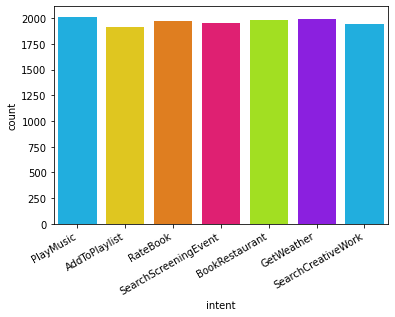

In [7]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment="right")

In [8]:
# This class handles the tokenizing and padding of our dataset. Each dataset will have a slightly different way to do each step. On regular
# TF packages, https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/2Cyzs/padding, you can see that they have methods that # tokenize and pad together that work seamlessly. Because we are using a pretrained model, bert-tf2, these are not available to us (not sure why tbh, probably because we want to use the pretrained tokenizer which requires us to not use TF methods)
class IntentDetection:
    DATA = "text"
    LABELS = "intent"

    def __init__(self, train, test,  classes, tokenizer:FullTokenizer, max_sequence_length=192):
        self.tokenizer = tokenizer
        self.max_sequence_length = 0
        self.classes = classes

        # train, test = map(lambda df: df.reindex(df[IntentDetection.DATA].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
        self.max_sequence_length = min(self.max_sequence_length, max_sequence_length)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])


    def _prepare(self, data_frame):
        x, y = [], []
        for _, row in tqdm.tqdm(data_frame.iterrows()):
            text, label = row[IntentDetection.DATA], row[IntentDetection.LABELS]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"]+tokens+["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

            self.max_sequence_length = max(self.max_sequence_length, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []

        for input_ids in ids:
            # cut_off = min(len(input_ids), self.max_sequence_length-2)
            cut_off = min(len(input_ids), self.max_sequence_length)
            input_ids[:cut_off] 
            input_ids = input_ids + [0]*(self.max_sequence_length-len(input_ids))
            x.append(np.array(input_ids))
        
        return np.array(x)

In [9]:
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
tokenizer = FullTokenizer(vocab_file="bert_en_uncased_L-12_H-768_A-12_2/assets/vocab.txt")

In [10]:
bert_model = tf.saved_model.load("./bert_en_uncased_L-12_H-768_A-12_2")

In [11]:
classes = train.intent.unique().tolist()
data = IntentDetection(train, test, classes, tokenizer,  max_sequence_length=192)

13784it [00:02, 5928.30it/s]
700it [00:00, 5877.03it/s]


In [12]:
def create_model(max_sequence_length, bert_model):
    tf.keras.backend.clear_session()

    input_layer = keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_layer")
    input_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="segment_ids")
    bert_layer = hub.KerasLayer(bert_model, trainable=True)
    pooled, seq = bert_layer([input_layer, input_mask, segment_ids])

    # input_l = tf.keras.layers.Input(shape=pooled.shape)
    # x = bert_layer()(input_l)

    # x = keras.layers.Lambda(lambda seq: seq[:, 0, :])(seq)
    # print(x.shape)
    x = keras.layers.Layer(pooled.shape)(pooled)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(768, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(len(classes), activation="softmax")(x)
    model = keras.Model([input_layer, input_mask, segment_ids], x, name="bert_model")
    return model

In [13]:
model = create_model(data.max_sequence_length, bert_model)
model.summary()

Model: "bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 38)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 38)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_layer[0][0]                
                                                                 input_mask[0][0]        

In [14]:
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [15]:
tok = tokenizer.tokenize("[CLS] listen to westbam alumb allergic on google music")
tokenizer.convert_tokens_to_ids(tok)

[1031,
 18856,
 2015,
 1033,
 4952,
 2000,
 2225,
 3676,
 2213,
 2632,
 25438,
 27395,
 2006,
 8224,
 2189]

In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [20]:
data.train_x.shape

(13784, 38)

In [21]:
mask = np.zeros(data.train_x.shape)
seg = np.zeros(data.train_x.shape)
history = model.fit(x=[data.train_x, mask, seg], y=data.train_y, validation_split=0.1, batch_size=16, shuffle=True, epochs=5)

Train on 12405 samples, validate on 1379 samples
Epoch 1/5
12405/12405 [==============================] - 72s 6ms/sample - loss: 1.4983 - sparse_categorical_accuracy: 0.6778 - val_loss: 1.1874 - val_sparse_categorical_accuracy: 0.9790
Epoch 2/5
12405/12405 [==============================] - 66s 5ms/sample - loss: 1.1893 - sparse_categorical_accuracy: 0.9811 - val_loss: 1.1811 - val_sparse_categorical_accuracy: 0.9848
Epoch 3/5
12405/12405 [==============================] - 66s 5ms/sample - loss: 1.1828 - sparse_categorical_accuracy: 0.9843 - val_loss: 1.1780 - val_sparse_categorical_accuracy: 0.9877
Epoch 4/5
12405/12405 [==============================] - 66s 5ms/sample - loss: 1.1806 - sparse_categorical_accuracy: 0.9858 - val_loss: 1.1805 - val_sparse_categorical_accuracy: 0.9855
Epoch 5/5
12405/12405 [==============================] - 67s 5ms/sample - loss: 1.1848 - sparse_categorical_accuracy: 0.9811 - val_loss: 1.1778 - val_sparse_categorical_accuracy: 0.9877


In [28]:
os.mkdir("saved_model", exist_ok=True)
tf.saved_model.save(model, "saved_model")

FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

In [27]:
mask = np.zeros(data.train_x.shape)
seg = np.zeros(data.train_x.shape)
tmask = np.zeros(data.test_x.shape)
tseg = np.zeros(data.test_x.shape)

train_loss, train_acc = model.evaluate([data.train_x, mask, seg], data.train_y, batch_size=16)
test_loss, test_acc = model.evaluate([data.test_x, tmask, tseg], data.text_y, batch_size=16)

print("train acc", train_acc)
print("train acc", test_acc)

700/700 [==============================] - 1s 1ms/sample - loss: 1.1919 - sparse_categorical_accuracy: 0.9743
train acc 0.9913668
train acc 0.9742857
